In [1]:
# Mümtaz Cem Eriş
# 504191531
#########################
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC


# Welcome to mid-project report!

## This jupyter notebook will guide you to what have been done in this project.


### Let's start with model hyperparameters.

## 1. Initialization

In [2]:
seed = 1075
np.random.seed(seed)
daily_confirmed_threshold = 5
daily_confirmed_threshold1 = 25
daily_confirmed_threshold2 = 125
daily_confirmed_threshold3 = 625
k_fold = 5
# originally cases start at '2020-01-19'
date_after = '2020-01-19'

# Classifiers
et = ExtraTreesClassifier()
knn = KNeighborsClassifier()
svc = SVC()
rg = RidgeClassifier()
gnb = GaussianNB()





Global hyperparameters can be observed here. Seed value for discrete randomization is set. There are four thresholds to flag coronavirus daily cases: 5, 25, 125, 625. This is carried out to make labeling harder for machine learning models as well as enhancing the model further by classifying wide range of daily case spectrum. k_fold is set to 5. The date that model is focusing on is after 2020-01-19. It is parametric, since there are not a lot of daily cases until February, one can observe changes when it is set to February.

## 2. Methods

In [3]:
def preprocessing(weather, time_prov):
    # starting from 2020-01-20 to 2020-06-30, 163 days
    ### Weather
    weather_ = weather[['province',
                        'max_wind_speed',
                        'avg_relative_humidity',
                        'date']]
    # First recorded corona date is 2020-01-20
    weather_ = weather_[(weather_['date'] > date_after)]
    weather_.reset_index(drop=True, inplace=True)
    # Correct misspelled province
    weather_['province'] = weather_.apply(lambda row:
                                          row['province'] if row[
                                                                 'province'] != 'Chunghceongbuk-do' else 'Chungcheongbuk-do'
                                          , axis=1)

    ### TimeProvinces
    time_prov_ = time_prov[['province',
                            'confirmed',
                            'date']]
    # Last recorded day is 2020-06-29
    time_prov_ = time_prov_[(time_prov_['date'] < '2020-06-30') & (time_prov_['date'] > date_after)]
    # Remove Sejong, as it is not presented in weather
    time_prov_ = time_prov_[(time_prov_['province'] != 'Sejong')]
    time_prov_.reset_index(drop=True, inplace=True)
    time_prov_.sort_values(by=['province', 'date'], inplace=True, ascending=True)
    time_prov_['daily'] = time_prov_['confirmed'] - time_prov_['confirmed'].shift(1)
    time_prov_.fillna(0, inplace=True)
    time_prov_['daily'] = time_prov_['daily'].apply(lambda row: 0 if row < 0 else row)
    print(time_prov_['daily'].describe())

    # cumulative status
    time_prov_cumulative = time_prov_.groupby(by='date').sum().reset_index()
    sns.scatterplot(x="date", y="daily", data=time_prov_cumulative)
    plt.title('Daily confirmed cases')
    plt.show()
    plt.savefig('daily_confirmed_cases.png')
    plt.clf()
    return weather_, time_prov_

def correlationGraphs(merged_df):
    f, ax = plt.subplots(figsize=(10, 8))
    corr = merged_df.corr()
    sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
                square=True, ax=ax)
    plt.title('Correlations Heatmap')
    plt.show()
    plt.savefig('correlation_heatmap.png')
    plt.clf()

    pd.plotting.scatter_matrix(merged_df, figsize=(20, 20))
    plt.title('Correlations Scatter')
    plt.savefig('correlation_scatter.png')
    plt.show()
    plt.clf()


def labelDailyCases(row):
    if row['daily'] > daily_confirmed_threshold3:
        return 4
    elif row['daily'] > daily_confirmed_threshold2:
        return 3
    elif row['daily'] > daily_confirmed_threshold1:
        return 2
    elif row['daily'] > daily_confirmed_threshold:
        return 1
    else:
        return 0


def addLabels(combined):
    combined['label'] = combined.apply(labelDailyCases, axis=1)
    # This code below only labels 0 and 1
    # combined['label'] = combined.apply(lambda row:
    #                                    1 if row['daily'] > daily_confirmed_threshold else 0
    #                                    , axis=1)
    return combined


def trainModel(Xtra_r, Ytra, model):
    # train model using given model
    model.fit(Xtra_r, Ytra)
    return model


def predict(model, Xtst_r):
    prediction = model.predict(Xtst_r)
    return prediction


def writeOutput(prediction, ytst, label):
    # compare prediction and ytst
    accuracy = accuracy_score(ytst, prediction)
    print("Accuracy: {0:.3f},  [{1} is used.]".format(accuracy, label))


def pcaAnalysis(df):
    X = df[list(df.columns.values.tolist())]
    print(X.shape)
    X.head()
    X = X.values
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(X)
    plt.clf()
    principalDF = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])
    ax = sns.scatterplot(x='PC1', y='PC2', data=principalDF)
    sns.regplot(x=principalDF['PC1'], y=principalDF['PC2'], fit_reg=False)
    plt.savefig("pca_analysis.png")
    plt.show()
    plt.clf()


This method would be used after the data is read from the file. Weather and Time Province data would be processed and data cleaning would be carried out. First of all, only 'max_wind_speed', 'avg_relative_humidity' columns are selected due to previous studies that are included in "Proje Önerisi". 


One can observe that at the "weather_['province']" line, there was a correction must be made in order to merge these two datasets. In the dataset, the province "Chunghceongbuk-do" is misspelled, and it is corrected as "Chungcheongbuk-do". Check the erroneous_weather_data figure below.

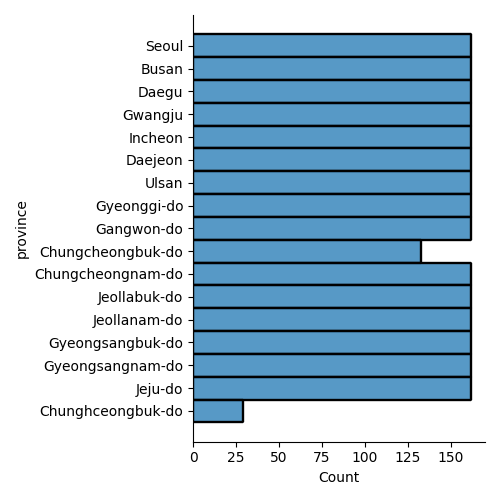


Now after the correction, the data would be as below.

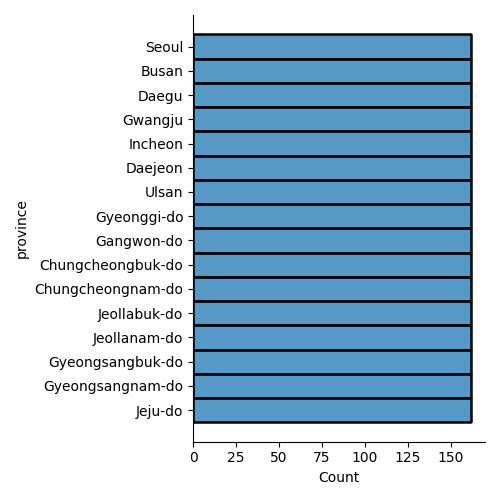


For the TimeProvince data, its date is set initially. Then the province Sejong is removed since weather data does not include Sejong province. Check the weather data figure below.


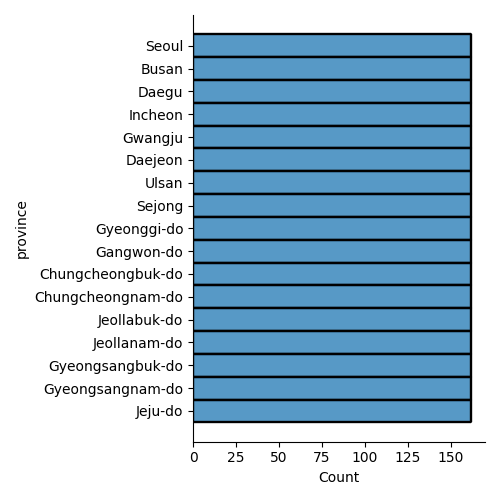


Finally, the values are sorted according to their provinces and daily cases are calculated. Since the confirmed column correspond to cumulative coronavirus cases, simple operations had to be carried out as can be observed above. After having daily column created, the cumulative status is shown as figure below.

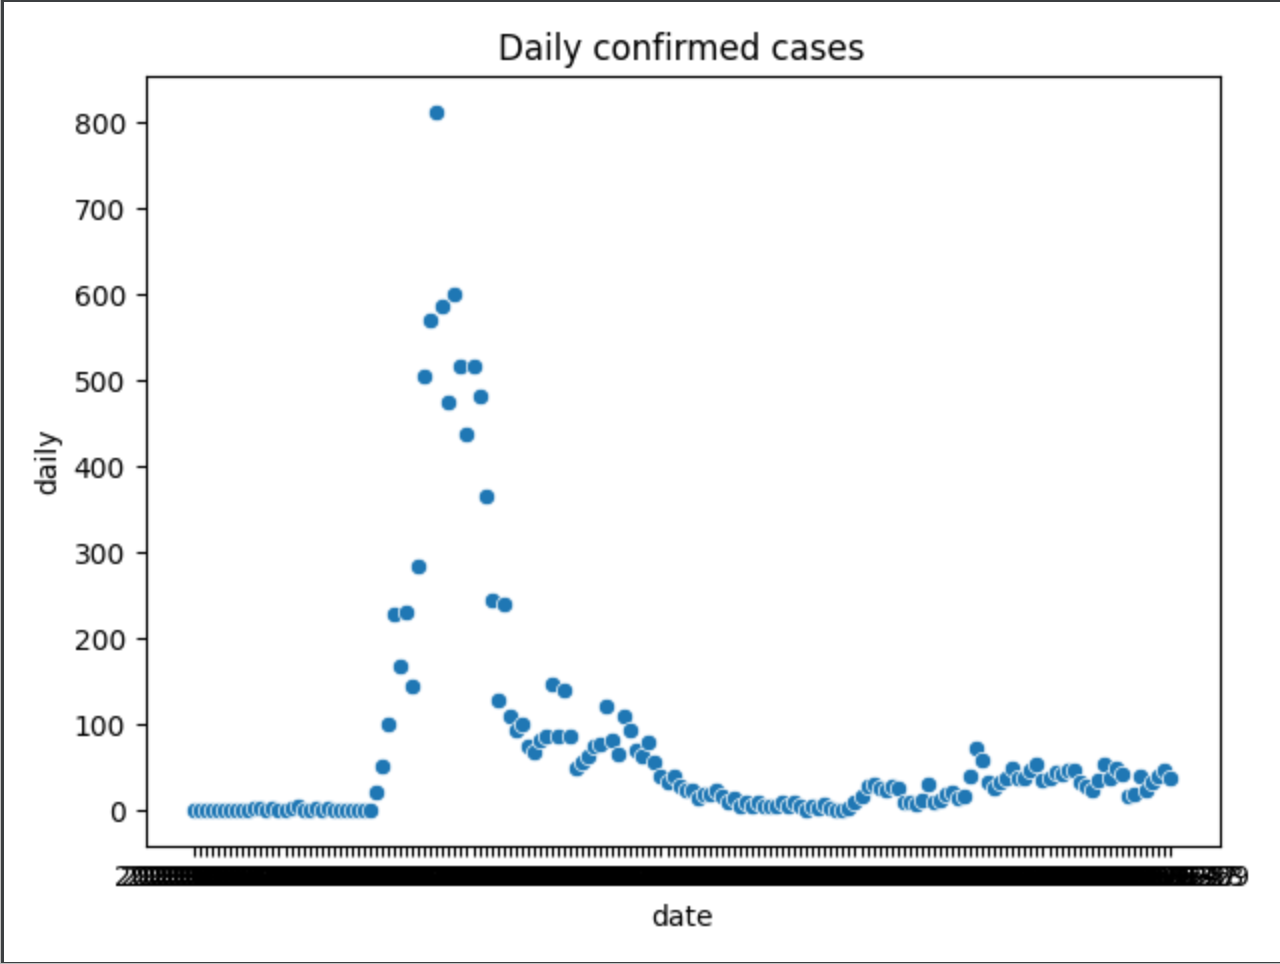



Other methods would be described in part 3.


## 3. Implementation

### 3.1 Preprocessing and Data Cleaning

In [4]:
time_prov = pd.read_csv('archive/TimeProvince.csv')
weather = pd.read_csv('archive/Weather.csv')
search_trend = pd.read_csv('archive/SearchTrend.csv')


Coronavirus search trends according to date can be observed below.

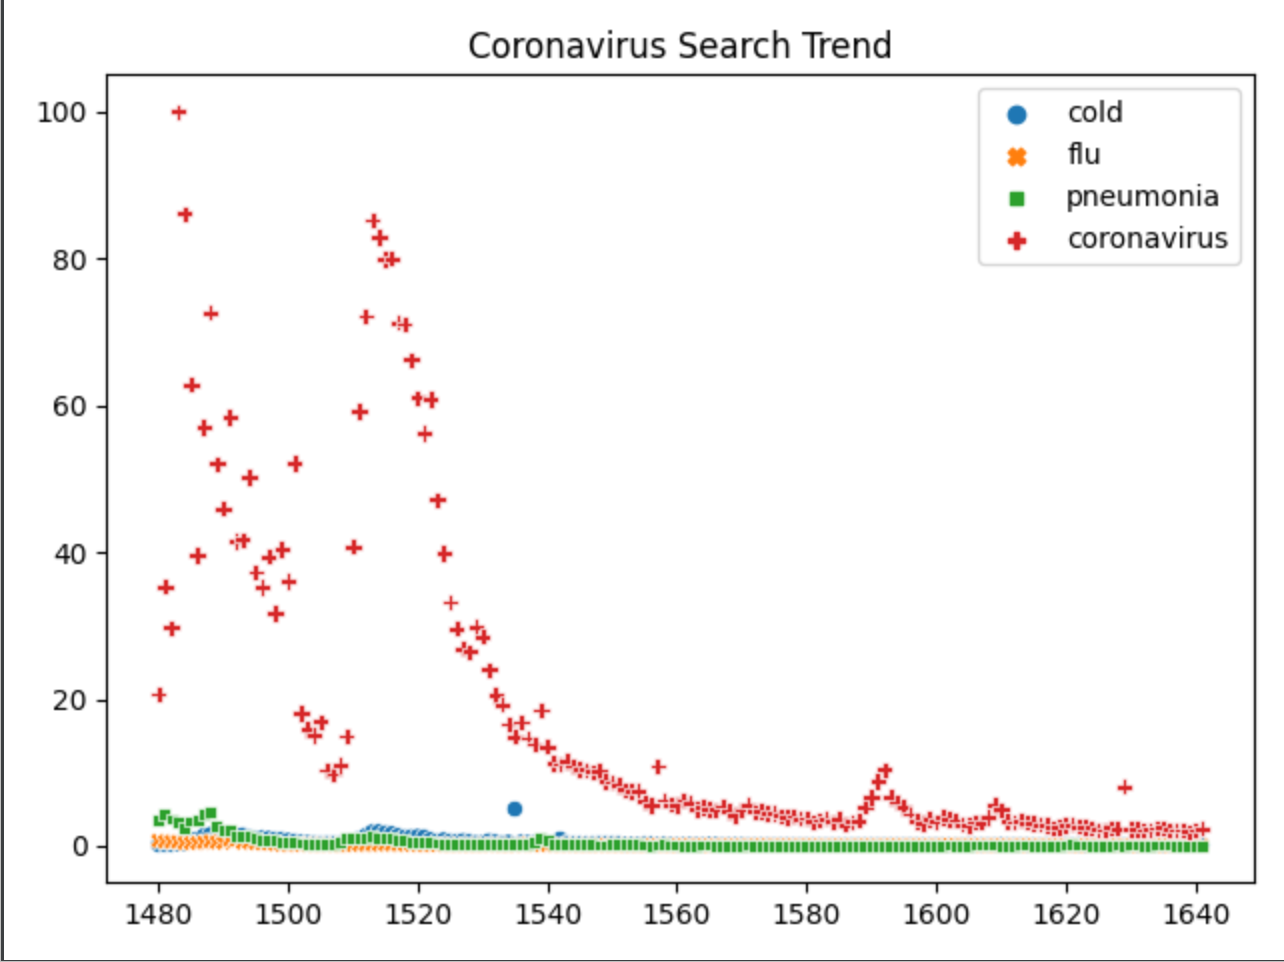



Preprocessing would be carried out after below.

count    2592.000000
mean        4.628858
std        30.191982
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max       656.000000
Name: daily, dtype: float64


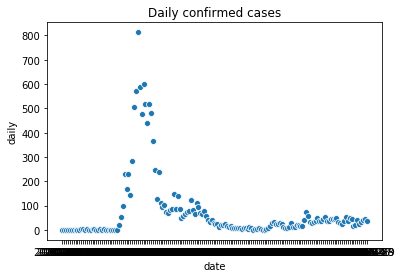

<Figure size 432x288 with 0 Axes>

In [5]:
weather_, time_prov_ = preprocessing(weather, time_prov)

### 3.2 Merging
As can be observed from the output of preprocessing, daily column is described and daily confirmed cases are printed. From the daily column, one sees that the mean value is 4.62, std is 30.191 and the maximum value is 656. This is essential, since these would be labeled as between 0-5, 5-25, 25-125 and 125-625, according to daily coronavirus cases with the machine learning model. The program will continue with merging weather, time province and search trend.

In [6]:
# Merge weather, time province and search trend
search_trend_date = search_trend[(search_trend['date'] > '2020-01-19')]
combined = pd.merge(weather_, time_prov_, on=['province', 'date'])
combined_all = pd.merge(combined, search_trend_date, on=['date'])
combined_all = combined_all.drop(columns=['date', 'confirmed'])
combined_all.head(10)


,province,max_wind_speed,avg_relative_humidity,daily,cold,flu,pneumonia,coronavirus
0,Seoul,5.7,46.8,0.0,0.19217,0.70343,3.63716,20.6961
1,Busan,6.1,45.6,0.0,0.19217,0.70343,3.63716,20.6961
2,Daegu,6.4,44.1,0.0,0.19217,0.70343,3.63716,20.6961
3,Gwangju,3.3,63.1,0.0,0.19217,0.70343,3.63716,20.6961
4,Incheon,8.6,56.0,0.0,0.19217,0.70343,3.63716,20.6961
5,Daejeon,5.5,57.3,0.0,0.19217,0.70343,3.63716,20.6961
6,Ulsan,3.6,48.5,0.0,0.19217,0.70343,3.63716,20.6961
7,Gyeonggi-do,6.4,68.5,0.0,0.19217,0.70343,3.63716,20.6961
8,Gangwon-do,5.2,38.8,0.0,0.19217,0.70343,3.63716,20.6961
9,Chungcheongbuk-do,5.6,63.3,0.0,0.19217,0.70343,3.63716,20.6961


### 3.3 Presenting Correlations and PCA

Here, the combined data frame can be observed above. It is now time to print the correlations between these features.

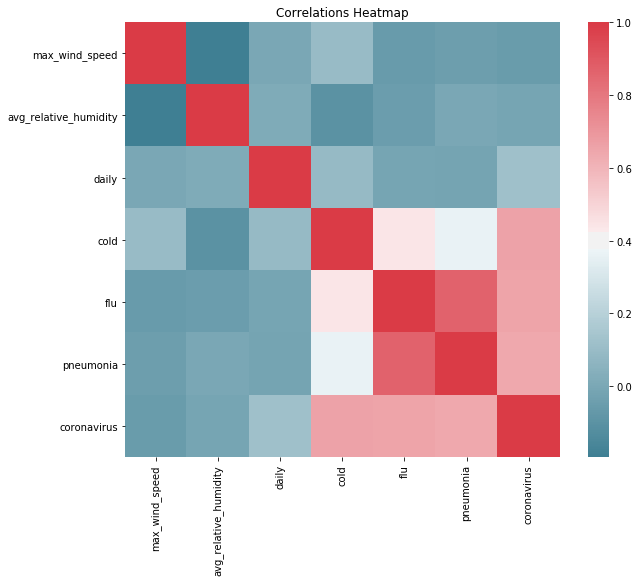

<Figure size 432x288 with 0 Axes>

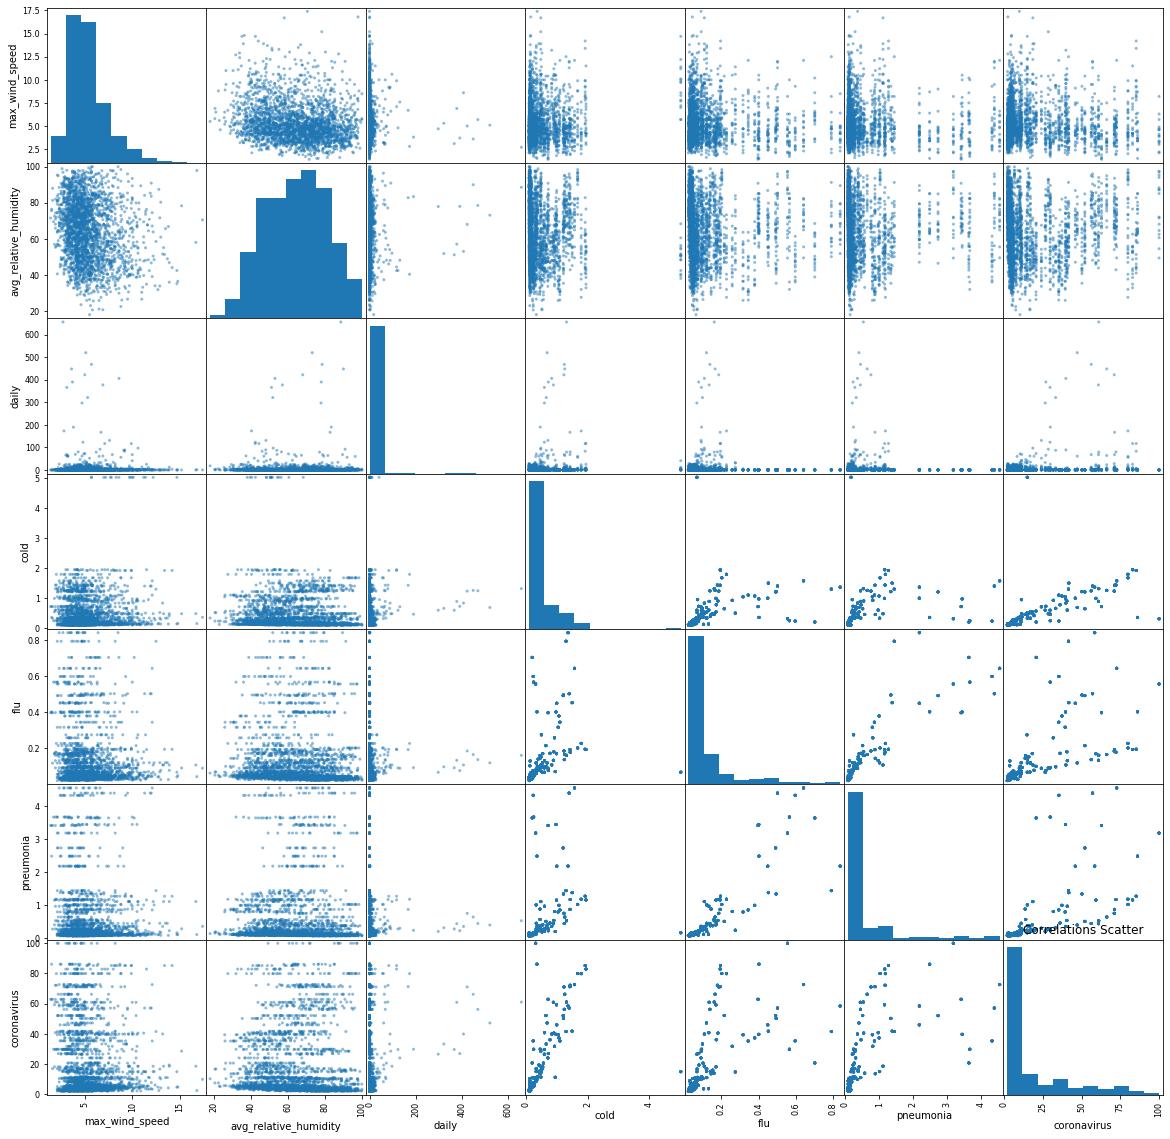

<Figure size 432x288 with 0 Axes>

In [8]:
# Print correlation graphs
correlationGraphs(combined_all.drop(columns=['province']))

When the code above is run, there will be two critical figures that would be presented. They are given below.

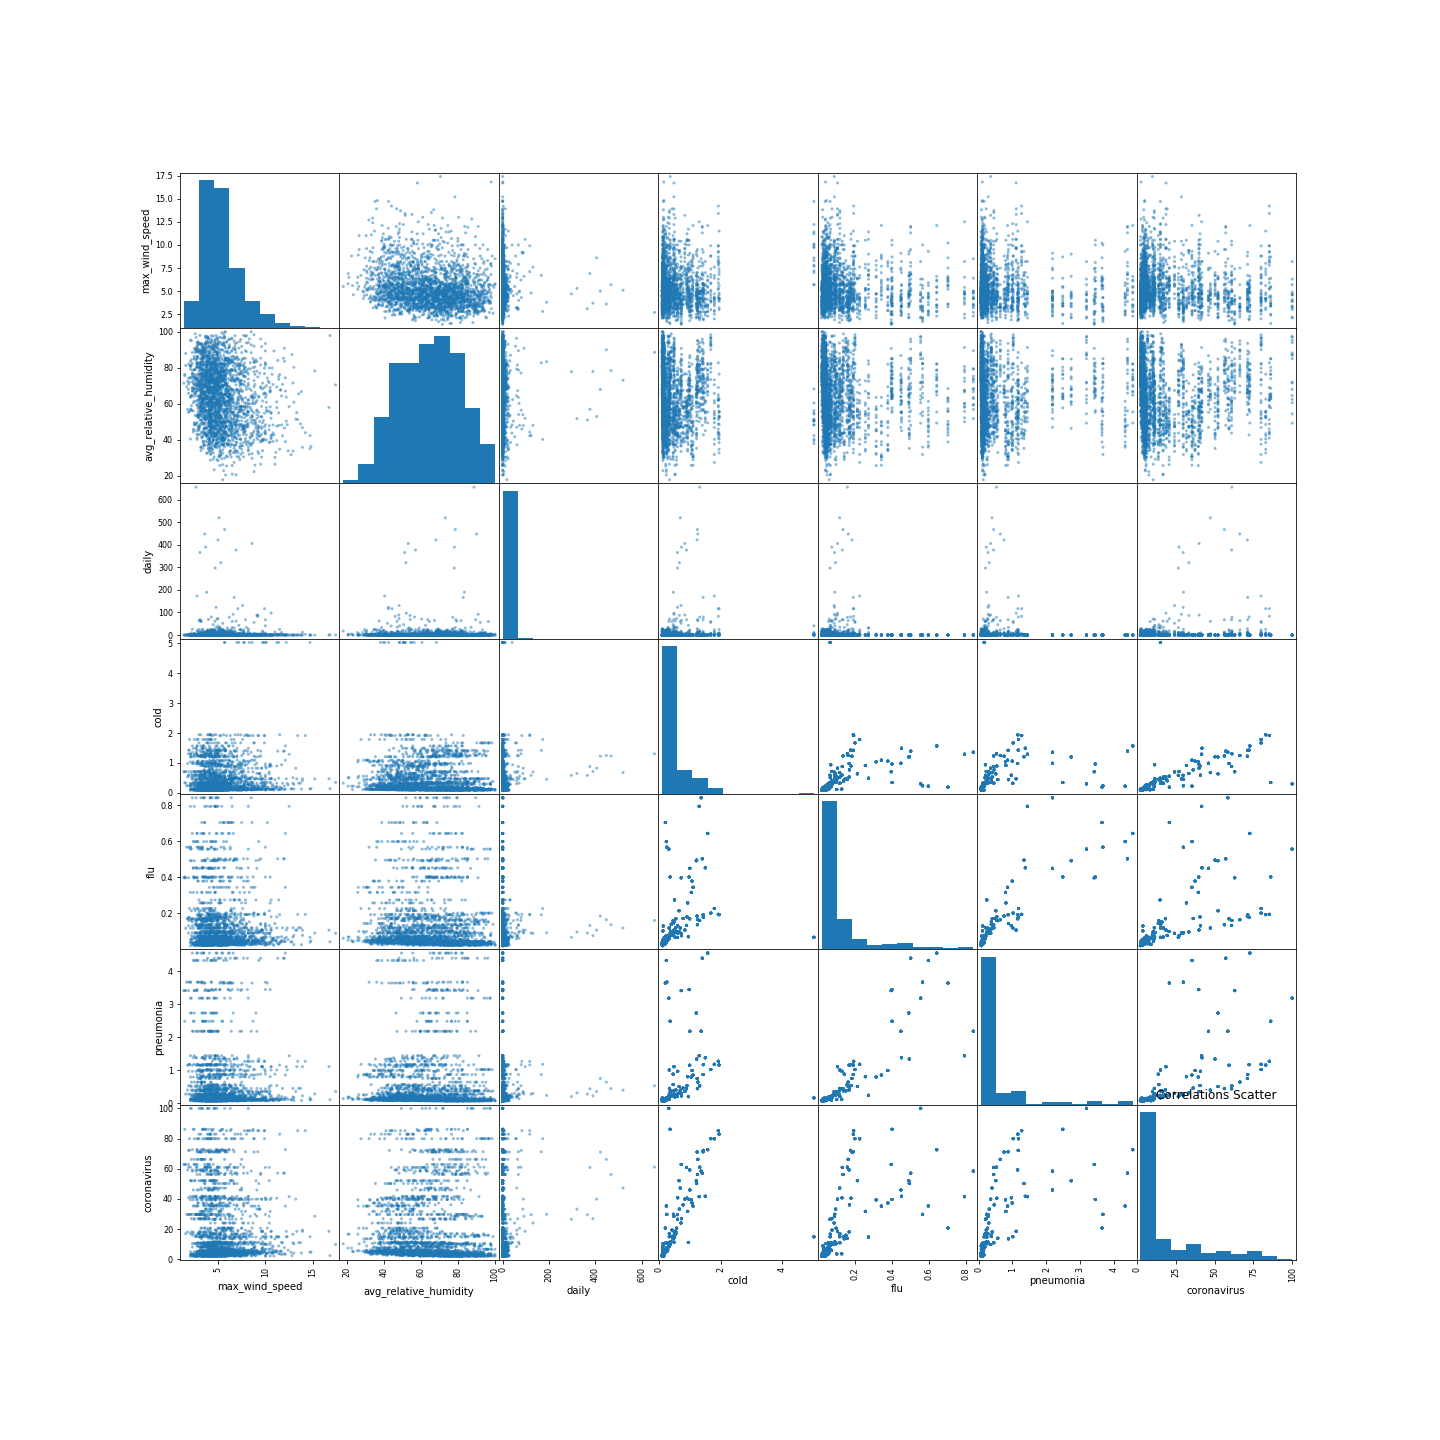


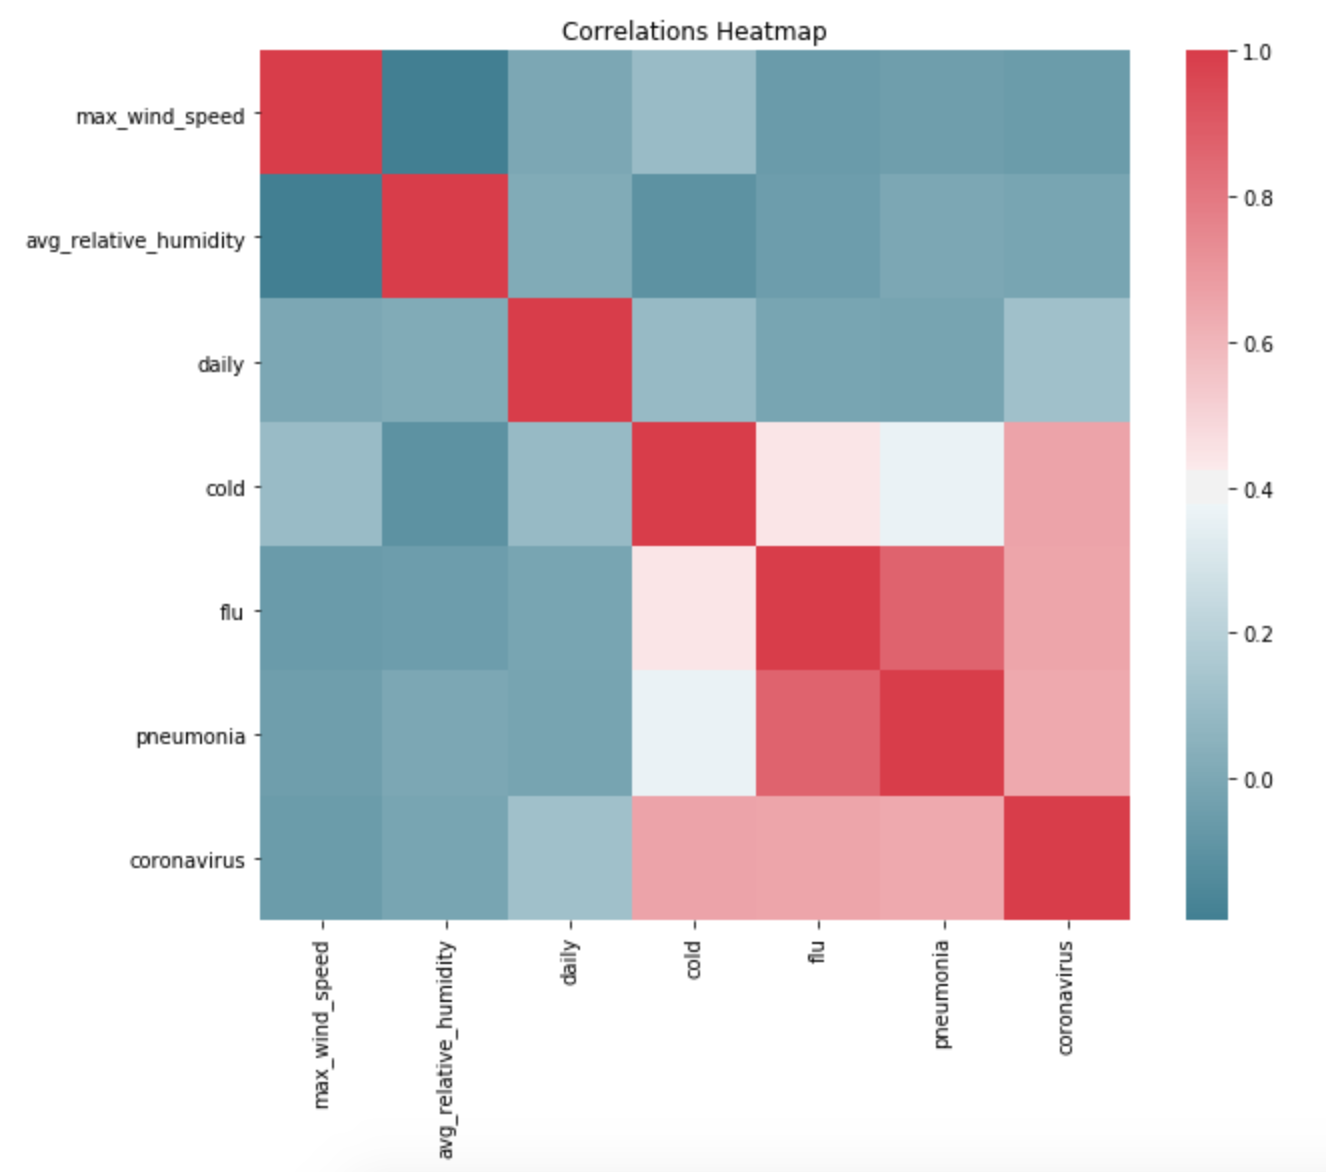


With the correlation scatter figure, it is quite obvious that the ones that correlate with 'daily' column are 'avg_relative_humidity' and 'coronavirus' columns. Thus, these two column would be used when the machine learning models are generated. Before that, the labels that are initiated as 0-5, 5-25 etc. would be assigned to the data frame as below.

In [9]:
# Add labels using daily_confirmed_threshold
combined_labeled = addLabels(combined_all)
combined_labeled['label'].describe()


count    2592.000000
mean        0.145833
std         0.439674
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         4.000000
Name: label, dtype: float64

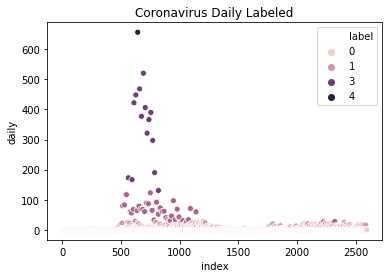

<Figure size 432x288 with 0 Axes>

In [10]:
combined_labeled['index'] = combined_labeled.index
plt.clf()
sns.scatterplot(x='index', y="daily", hue="label", data=combined_labeled)
plt.title('Coronavirus Daily Labeled')
plt.savefig('coronavirus_daily_labeled.png')
plt.show()
plt.clf()

### 3.4 Labeling

The labels are added using 'addLabels' method as described above. The labeled coronavirus daily cases can be observed below.

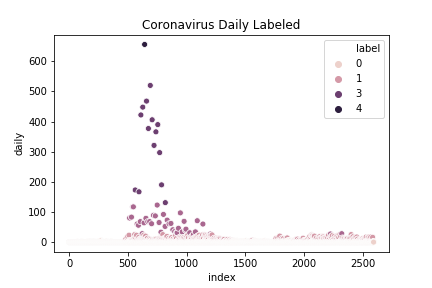

Here, the columns that do not have positive correlation with 'daily' would be dropped.

In [11]:
# Both avg_relative_humidity and coronavirus have positive correlation.
# Therefore, drop other columns.
combined_reduced = combined_labeled.drop(columns=['cold', 'flu', 'pneumonia', 'max_wind_speed'])

### 3.5 Encoding Provinces

The provinces are one of the key components in the data, therefore they are included in dataset after having transformed onto 0s and 1s as below.

In [12]:
# Encoding provinces with 0s and 1s
encoder = OneHotEncoder(categories='auto', sparse=False)
encoder.fit(np.array(combined_reduced['province']).reshape(-1, 1))
inf_dummies = encoder.transform(np.array(combined_reduced['province']).reshape(-1, 1))
dummies = pd.DataFrame(inf_dummies.astype(int), columns=['province_' + x for x in encoder.categories_[0]])
combined_reduced = combined_reduced.join(dummies)
# Drop province, index and daily column as it is not needed anymore
combined_ready = combined_reduced.drop(columns=['province', 'daily', 'index'])
combined_ready.head(10)

,avg_relative_humidity,coronavirus,label,province_Busan,province_Chungcheongbuk-do,province_Chungcheongnam-do,province_Daegu,province_Daejeon,province_Gangwon-do,province_Gwangju,province_Gyeonggi-do,province_Gyeongsangbuk-do,province_Gyeongsangnam-do,province_Incheon,province_Jeju-do,province_Jeollabuk-do,province_Jeollanam-do,province_Seoul,province_Ulsan
0,46.8,20.6961,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,45.6,20.6961,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,44.1,20.6961,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,63.1,20.6961,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,56.0,20.6961,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
5,57.3,20.6961,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
6,48.5,20.6961,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
7,68.5,20.6961,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
8,38.8,20.6961,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
9,63.3,20.6961,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### 3.6 K-Fold Cross Validation

The data is processed and is ready to be trained. Before that, KFold would be created and the data would split as training and testing. The label array would be substracted from the main array. There are 2592 rows and 22 features in the final combined numpy array.

In [13]:
# K-fold cross validation
kf = KFold(n_splits=k_fold, shuffle=True, random_state=2)
X = combined_ready.drop(columns=['label']).to_numpy()
Y = combined_ready['label'].to_numpy()
combined_arr = combined_ready.to_numpy()
combined_arr.shape

(2592, 19)

### 3.7 Machine Learning and Results

Finally, the data would be trained using the classification methodologies below. The data would be split using KFold, and the results would be printed for each fold and each classifier.

In [14]:
labels_clf = ['ExtraTrees', 'KNeighbors', 'SVC', 'Ridge', 'GaussianNB']
i = 1
for train_index, test_index in kf.split(combined_arr):
    print("***", i, "-Fold Results***")
    xtra, xtst = X[train_index], X[test_index]
    ytra, ytst = Y[train_index], Y[test_index]

    # Classifiers cross-validation
    # Each of models would be trained and their
    # cross validation score would be printed.
    for model, label in zip([et, knn, svc, rg, gnb], labels_clf):
        trained_model = trainModel(xtra, ytra, model)
        prediction = predict(trained_model, xtst)
        writeOutput(prediction, ytst, label)

    i += 1


*** 1 -Fold Results***
Accuracy: 0.906,  [ExtraTrees is used.]
Accuracy: 0.890,  [KNeighbors is used.]
Accuracy: 0.888,  [SVC is used.]
Accuracy: 0.894,  [Ridge is used.]
Accuracy: 0.443,  [GaussianNB is used.]
*** 2 -Fold Results***
Accuracy: 0.894,  [ExtraTrees is used.]
Accuracy: 0.886,  [KNeighbors is used.]
Accuracy: 0.888,  [SVC is used.]
Accuracy: 0.884,  [Ridge is used.]
Accuracy: 0.472,  [GaussianNB is used.]
*** 3 -Fold Results***
Accuracy: 0.886,  [ExtraTrees is used.]
Accuracy: 0.882,  [KNeighbors is used.]
Accuracy: 0.875,  [SVC is used.]
Accuracy: 0.867,  [Ridge is used.]
Accuracy: 0.502,  [GaussianNB is used.]
*** 4 -Fold Results***
Accuracy: 0.886,  [ExtraTrees is used.]
Accuracy: 0.865,  [KNeighbors is used.]
Accuracy: 0.861,  [SVC is used.]
Accuracy: 0.875,  [Ridge is used.]
Accuracy: 0.481,  [GaussianNB is used.]
*** 5 -Fold Results***
Accuracy: 0.913,  [ExtraTrees is used.]
Accuracy: 0.896,  [KNeighbors is used.]
Accuracy: 0.898,  [SVC is used.]
Accuracy: 0.896,  [R

### 4. Conclusions

It can be observed that other than GaussianNB, all other classifiers have achieved quite high accuracies. The models are certainly successful due to positive correlations and the lack of data. Since the government of Korea has stopped sharing the data, there are only limited data to be gathered. For future, for different countries including Turkey, the search trends from Google and the weather data can be collected and be processed just as above in order to give daily coronavirus predictions about future. It would be highly beneficial since considerable amount of countries are having trouble with dealing the virus, they are setting limitations and constraints to their citizens without using prediction models such as these. 